In [2]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
using HePPCAT
using Statistics
using Measures
using BenchmarkTools
#using PGFPlotsX
#using WeightedPCA
include("../alpcahFamily.jl")
include("../helperFunctions.jl")

heppcatWrapper_known (generic function with 1 method)

In [3]:
Yfull, vfull = load("astroData.jld", "Yfull", "vfull");

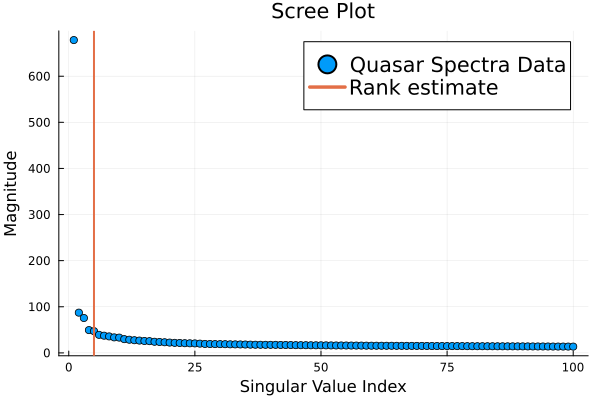

In [4]:
k = 5 # rank estimate
scatter(svdvals(Yfull[:,1:2000])[1:100], title="Scree Plot", label="Quasar Spectra Data", xlabel="Singular Value Index", ylabel="Magnitude", legendfontsize=14)
vline!([k], linewidth=2, label="Rank estimate")

In [5]:
Utrue = svd(Yfull[:,1:1000]).U[:,1:k] # ground truth subspace
testidx = 1001:10000
Y = Yfull[:,testidx]
v = vfull[testidx]
n = length(v);
Ylist = []
for i = 1:n
    push!(Ylist, Y[:,i])
end
nothing

In [5]:
function POGM_RPCA(Y, λr, r; niter::Int=100)
    M,N = size(Y)
    A = hcat(Matrix(1.0I, M, N),Matrix(1.0I, M, N))
    B = vcat(A,A)
    Lf = opnorm(B)
    x0 = vcat(zeros(size(Y)),zeros(size(Y)))
    grad = K -> repeat(-1*(Y-K[1:M,:]-K[M+1:end,:]),2,1)
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function svst(x,t)
        U,S,Vt = svd(x)
        return U*diagm(soft.(S, t))*Vt'
    end
    prox1 = (z,c) -> vcat(svst(z[1:M,:], c*λr), soft(z[M+1:end,:], c))
    #prox1 = (z,c) -> vcat(svst(z[1:M,:], c), soft(z[M+1:end,:], λr*c))
    K, _ = pogm_restart(x0, x->0, grad, Lf ; g_prox=prox1, niter=niter, mom=:fpgm, restart=:gr)
    K = K[1:M,:] #,K[M+1:end,:]  Outlier matrix
    return svd(K).U[:,1:r]
end
function validateRPCA(Ytrain, Utrain, r, niter)
    λ = [0.001; 0.01; 0.1; 1; 10; 15; 20; 30; 40; 50; 60; 70; 80; 90; 100]
    errors = zeros(length(λ))
    Threads.@threads for k=1:length(λ)
        U_RPCA = POGM_RPCA(Ytrain, λ[k], r; niter=niter)
        errors[k] = affinityError(Utrain, U_RPCA)
    end
    λ1 = λ[argmin(errors)]
    return λ1
end

validateRPCA (generic function with 1 method)

In [6]:
splitSize = round(Int, 1000)
num_trials = 50;
niters = 100;
testShuffle = shuffle(1:n)[1:splitSize]
Ymat_test = Y[:,testShuffle];
v_test = v[testShuffle];

In [7]:
U_ALPCAH = ALPCAH(Ymat_test, k, 1000; μ=2, ρ=1.01, alpcahIter=100) # mu=1 and p=1.01
affinityError(Utrue, U_ALPCAH)

0.4231935336038508

In [8]:
U_ALPCAH_LR = LR_ALPCAH(Ymat_test, k; alpcahIter=100)
affinityError(Utrue, U_ALPCAH_LR)

0.42432178853694597

In [9]:
validateRPCA(Ymat_test, Utrue, k, 100)

30.0

In [10]:
U_RPCA = POGM_RPCA(Ymat_test, 20, k; niter=100)
affinityError(Utrue, U_RPCA)

0.47211927720420693

In [11]:
U_WPCA = weightedPCA(Ymat_test , v_test, k)
affinityError(Utrue, U_WPCA)

0.4601544278711981

In [12]:
U_ALPCAH_NUC = ALPCAH_NUCLEAR(Ymat_test, k, 75; μ=2, ρ=1.01, alpcahIter=100)
affinityError(Utrue, U_ALPCAH_NUC)

0.506742391114948

In [13]:
splitSize = round(Int, 1000)
num_trials = 50;
niters = 100;

num_methods = 6
errors_subspaces = zeros(num_methods,num_trials)

p = Progress(num_trials; dt=1)
#Threads.@threads for iter=1:num_trials
for iter=1:num_trials
    #trainShuffle = shuffle(1:dataSize)[1:splitSize]
    testShuffle = shuffle(1:n)[1:splitSize]

    #Ymat_train = Ytrain[:,trainShuffle]
    Ymat_test = Y[:,testShuffle]
    v_test = v[testShuffle]

    ### Homoscedastic PPCA both groups
    U_PCA = PCA(Ymat_test, k)

    #U_PCAGOOD = PCA(Y[:,shuffle(1:2000)[1:splitSize]], k) #PCA(Y[:,1:splitSize], k) #PCA(Y[:,randperm(1000)[1:500]], k)

    #HEPPCAT UNGROUPED
    Ylist_test = []
    for t=1:splitSize
        push!(Ylist_test, Ymat_test[:,t])
    end
    Mheppcat = heppcat(Ylist_test,k,niters; varfloor=1e-9)

    # LR-ALPCAH
    U_ALPCAH_LR = LR_ALPCAH(Ymat_test, k; alpcahIter=100)

    # ALPCAH
    U_ALPCAH = ALPCAH(Ymat_test, k, 1000; μ=2, ρ=1.01, alpcahIter=100)

    # ALPCAH-NUCLEAR
    U_ALPCAH_NUC = ALPCAH_NUCLEAR(Ymat_test, k, 75; μ=2, ρ=1.01, alpcahIter=100)

    # RPCA
    U_RPCA = POGM_RPCA(Ymat_test, 20, k; niter=100)

    # WPCA
    #U_WPCA = weightedPCA(Ymat_test , v_test.^-1, k)

    # errors = []
    subspaces = [U_PCA, U_RPCA, Mheppcat.U, U_ALPCAH_NUC, U_ALPCAH, U_ALPCAH_LR]
    for (i,U) in enumerate(subspaces)
        errors_subspaces[i,iter] = affinityError(Utrue, U)
    end
    next!(p)
end
finish!(p)
#errorPCAGOOD = affinityError(Utrue, PCA(Y[:,1:1000], k));

Progress: 100%|█████████████████████████████████████████| Time: 0:10:34


In [14]:
color = palette(:default)

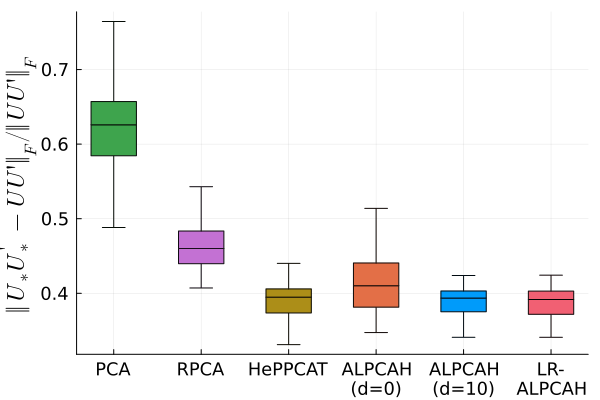

In [17]:
using LaTeXStrings
xvalues = ["PCA" "RPCA" "HePPCAT" "ALPCAH\n(d=0)" "ALPCAH\n(d=10)" "LR-\nALPCAH"]
boxplot( xvalues, errors_subspaces', leg = false,title="",legendfontpointsize=14,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18,outliers=false,
    color=[color[3] color[4] color[5] color[2] color[1] color[end-2]], xticks=true, bar_width = 0.7,
    ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", yticks = :native, label=["PCA" "HePPCAT" "RPCA" "LR-ALPCAH" "ALPCAH (d=10)" "ALPCAH (d=0)"])
#hline!([errorPCAGOOD], linewidth=3, color=:brown)
#annotate!(0.66, 0.425, text("PCA-GOOD", :brown,))
#savefig("result_subspaces.svg")

In [22]:
mean(errors_subspaces, dims=2)

6×1 Matrix{Float64}:
 0.655146729886401
 0.3861351635516214
 0.4583983066674348
 0.3802053581722876
 0.38024837623910246
 0.41175658576394936

In [23]:
testShuffle = shuffle(1:n)[1:1000]
Ymat_test = Y[:,testShuffle]
Ylist_test = []
for t=1:1000 #size(Y)[2]
        push!(Ylist_test, Ymat_test[:,t])
end

In [26]:
trialALPCAH = @benchmark ALPCAH_NUCLEAR(Ymat_test, k, 75; μ=2, ρ=1.01, alpcahIter=100)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.404 s …  2.421 s  ┊ GC (min … max): 1.99% … 2.03%
 Time  (median):     2.420 s             ┊ GC (median):    1.98%
 Time  (mean ± σ):   2.415 s ± 9.612 ms  ┊ GC (mean ± σ):  2.00% ± 0.03%

  █                                                  █   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  2.4 s         Histogram: frequency by time        2.42 s <

 Memory estimate: 3.75 GiB, allocs estimate: 4866.

In [27]:
round((median(trialALPCAH).time)/1e9, digits=1) # ms

2.4

In [29]:
round((median(trialALPCAH).memory/1024)/1024, digits=1) # MiB

3838.6

In [21]:
trialPCA = @benchmark PCA(Ymat_test, k);
trialHEPPCAT = @benchmark heppcat(Ylist_test, k, 100; varfloor=1e-9)
trialALPCAH = @benchmark ALPCAH(Ymat_test, k, 1000; μ=2, ρ=1.01, alpcahIter=100)
trialALPCAHLR = @benchmark LR_ALPCAH(Ymat_test, k; alpcahIter=100)
trialRPCA = @benchmark POGM_RPCA(Ymat_test, 25, k; niter=100);

In [15]:
round((median(trialPCA).time)/1e9, digits=1) # ms

0.0

In [16]:
round((median(trialPCA).memory/1024)/1024, digits=1) # MiB

0.8

In [22]:
timePCA, memoryPCA = round((median(trialPCA).time)/1e6, digits=1), round((median(trialPCA).memory/1024)/1024, digits=1)
timeHEPPCAT, memoryHEPPCAT = round((median(trialHEPPCAT).time)/1e6, digits=1), round((median(trialHEPPCAT).memory/1024)/1024, digits=1)
timeALPCAH, memoryALPCAH = round((median(trialALPCAH).time)/1e6, digits=1), round((median(trialALPCAH).memory/1024)/1024, digits=1)
timeALPCAHLR, memoryALPCAHLR = round((median(trialALPCAHLR).time)/1e6, digits=1), round((median(trialALPCAHLR).memory/1024)/1024, digits=1)
timeRPCA, memoryRPCA = round((median(trialRPCA).time)/1e6, digits=1), round((median(trialRPCA).memory/1024)/1024, digits=1);

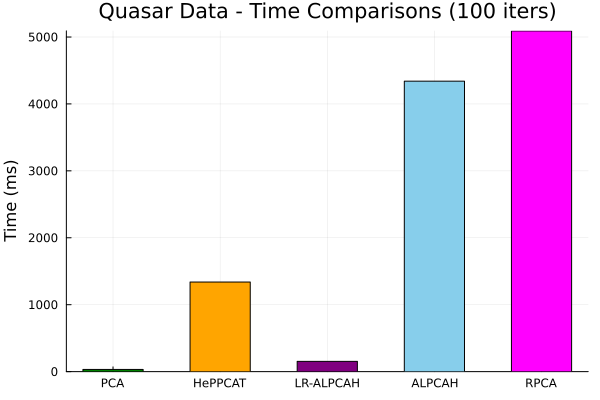

In [23]:
bar(["PCA" "HePPCAT" "LR-ALPCAH" "ALPCAH" "RPCA"], [timePCA timeHEPPCAT timeALPCAHLR timeALPCAH timeRPCA], leg = false,title="Quasar Data - Time Comparisons (100 iters)",color=[:green :orange :purple :skyblue :magenta], ylabel="Time (ms)", yticks = :native)
#savefig("result_time.pdf")

In [25]:
[timePCA timeHEPPCAT timeALPCAHLR timeALPCAH timeRPCA]

1×5 Matrix{Float64}:
 32.4  1339.1  153.5  4339.9  5091.8

In [26]:
[memoryPCA memoryHEPPCAT memoryALPCAHLR memoryALPCAH memoryRPCA]

1×5 Matrix{Float64}:
 7.3  5731.6  459.0  3838.8  7977.5

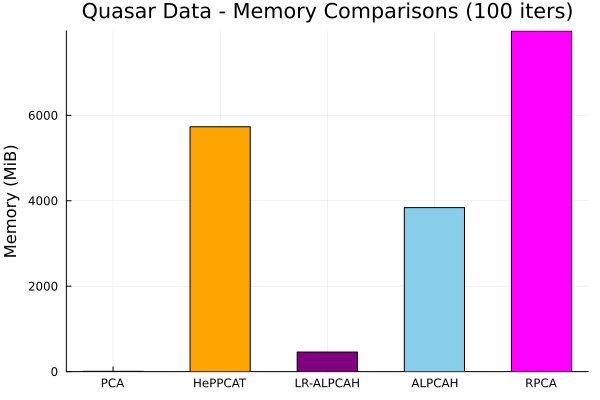

In [24]:
bar(["PCA" "HePPCAT" "LR-ALPCAH" "ALPCAH" "RPCA"], [memoryPCA memoryHEPPCAT memoryALPCAHLR memoryALPCAH memoryRPCA], leg = false,title="Quasar Data - Memory Comparisons (100 iters)",color=[:green :orange :purple :skyblue :magenta], ylabel="Memory (MiB)", yticks = :native)
#savefig("result_memory.pdf")

In [6]:
U_LRALPCAH = LR_ALPCAH(Y, k; alpcahIter=100)
varLRALPCAH = grouplessVarianceUpdate(Y, U_LRALPCAH*U_LRALPCAH'*Y; varfloor=0.1);

In [7]:
# Ylist_test = []
# for t=1:size(Y)[2]
#         push!(Ylist_test, Y[:,t])
# end
# U_HEPPCAT = heppcat(Ylist_test, k, 1000; varfloor=1e-9).U
# varHEPPCAT = grouplessVarianceUpdate(Y, U_HEPPCAT*U_HEPPCAT'*Y; varfloor=0.1);

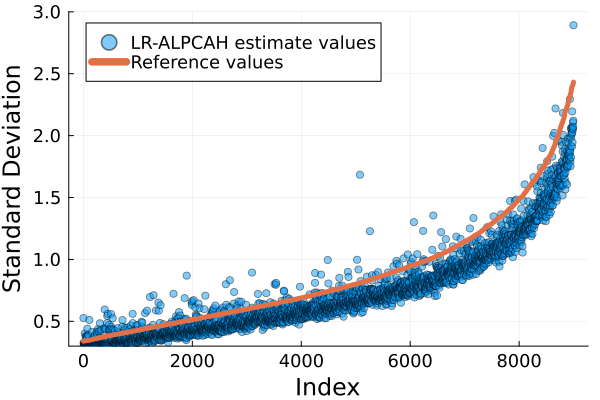

In [41]:
plot(title="", xlabel="Index", ylabel="Standard Deviation", legendfontsize=12, ylim=(0.3,3),legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18)
reductionFactor = 3
scatter!(1:reductionFactor:length(varLRALPCAH), varLRALPCAH[1:reductionFactor:end].^0.5, linewidth=1.5, label="LR-ALPCAH estimate values", alpha=0.5, markersize=4)
plot!(1:reductionFactor:length(v), v[1:reductionFactor:end].^0.5, linewidth=5, label="Reference values")
#savefig("result_standard_deviations.pdf")